# Milestone 2
## 2.1 Imports and data loading

In [102]:
import findspark
findspark.init()
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import to_timestamp, dayofmonth, dayofweek, month, year, length, udf
import pyspark.sql.functions as f

import seaborn as sns

import pandas as pd

In [4]:
DATA_PATH = 'data/'
FILE_NAME_00 = 'amazon_reviews_us_Books_v1_00.tsv.gz'
FILE_NAME_01 = 'amazon_reviews_us_Books_v1_01.tsv.gz'
FILE_NAME_02 = 'amazon_reviews_us_Books_v1_02.tsv.gz'
FILE_NAME_US = 'amazon_reviews_multilingual_US_v1_00.tsv.gz'
FILE_NAME_UK = 'amazon_reviews_multilingual_UK_v1_00.tsv.gz'
FILE_NAME_FR = 'amazon_reviews_multilingual_FR_v1_00.tsv.gz'
FILE_NAME_DE = 'amazon_reviews_multilingual_DE_v1_00.tsv.gz'
FILE_NAME_JP = 'amazon_reviews_multilingual_JP_v1_00.tsv.gz'

In [135]:
data_00 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_00)
data_01 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_01)
data_02 = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME_02)

data = data_00.union(data_01).union(data_02)
#data = data_00

In [136]:
avg_stars = data.groupby('product_id', 'product_title').agg({"star_rating" : "avg", "review_id" : "count", "helpful_votes" : "sum", "total_votes" : "sum"})
avg_stars.persist()

DataFrame[product_id: string, product_title: string, count(review_id): bigint, sum(total_votes): double, avg(star_rating): double, sum(helpful_votes): double]

In [137]:
avg_stars = avg_stars.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('sum(total_votes)', 'total_votes') \
                        .withColumnRenamed('sum(helpful_votes)', 'helpful_votes') \
                        .withColumnRenamed('avg(star_rating)', 'rating') \

In [138]:
avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|     1003|     1842.0| 4.154536390827517|       1441.0|
|0062091158|     King (Prophecy)|        2|        1.0|               4.0|          1.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       30|      519.0|               4.6|        439.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|019513172X|Nothing but Chris...|        2|        1.0|               4.5|          1.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: Fro

In [9]:
avg_stars.count()

2274618

In [139]:
main_avg_stars = avg_stars.where('n_reviews > 10')

In [140]:
main_avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|     1003|     1842.0| 4.154536390827517|       1441.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       30|      519.0|               4.6|        439.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: From Lost t...|     1350|     2734.0| 4.099259259259259|       2203.0|
|1416299025|Outlander 2016 Bo...|       11|       54.0|4.7272727272727275|         50.0|
|0060192674|Everythin

In [141]:
main_avg_stars.count()

358136

In [17]:
by_product = main_avg_stars.toPandas()

In [18]:
by_product['ratio_helpful'] = by_product['helpful_votes'] / by_product['total_votes']

In [ ]:
by_product.sort_values(by='n_reviews')

## 2.2 Rating vs vote counts & helpful votes

In [34]:
grouped_product_ratio = by_product.groupby([pd.cut(by_product['ratio_helpful'], bins=50, include_lowest=True)]).mean()

In [35]:
grouped_product_ratio.head()

,n_reviews,total_votes,rating,helpful_votes,ratio_helpful
ratio_helpful,,,,,
"(-0.002, 0.02]",16.917382,3.242523,4.524375,0.000592,0.000004
"(0.02, 0.04]",32.625000,39.625000,4.524151,1.333333,0.034391
"(0.04, 0.06]",26.079646,31.141593,4.505108,1.592920,0.051706
"(0.06, 0.08]",23.104478,30.711443,4.430526,2.179104,0.071093
"(0.08, 0.1]",22.717143,29.394286,4.389249,2.682857,0.092393


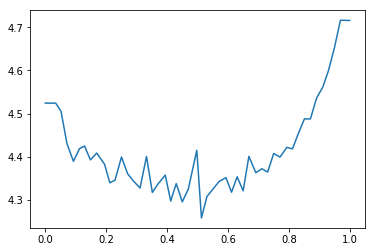

In [31]:
plt.plot(grouped_product_ratio['ratio_helpful'], grouped_product_ratio['rating'])

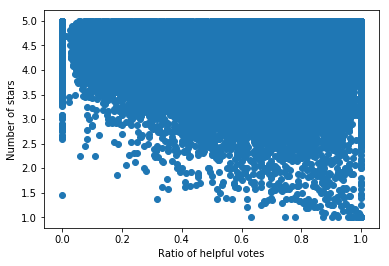

In [23]:
plt.scatter(by_product['ratio_helpful'], by_product['rating'])
plt.xlabel('Ratio of helpful votes')
plt.ylabel('Number of stars')
plt.show()

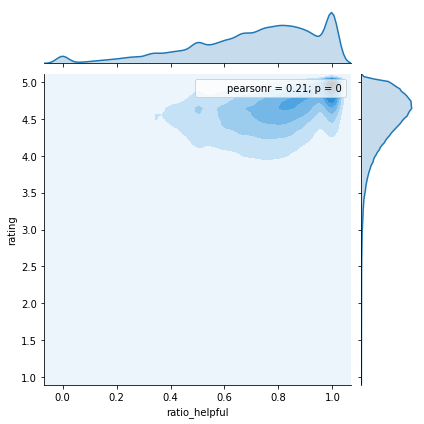

In [45]:
sns.jointplot(x = by_product['ratio_helpful'], y = by_product['rating'], kind='kde')

**Observation**<br>
We can see that the lower the number of helpful votes is, the higher the rating. However, unfortunately we cannot come up with an possible explanation for the ratio of helpful votes to influence the rating, so we cannot reason if the relationship is causal.

In [60]:
grouped_product_n_reviews = by_product.groupby([pd.cut(by_product['n_reviews'], bins=np.logspace(1, 3), include_lowest=True)]).mean()
grouped_product_n_reviews

,n_reviews,total_votes,rating,helpful_votes,ratio_helpful
n_reviews,,,,,
"(9.999, 10.985]",NaN,NaN,NaN,NaN,NaN
"(10.985, 12.068]",11.457496,22.154028,4.468589,15.778729,0.718889
"(12.068, 13.257]",13.000000,26.126264,4.472138,18.482839,0.716416
"(13.257, 14.563]",14.000000,28.158834,4.476638,19.881041,0.713630
"(14.563, 15.999]",15.000000,30.292548,4.468246,21.485771,0.713505
"(15.999, 17.575]",16.465675,34.735785,4.474098,24.608667,0.714995
"(17.575, 19.307]",18.475165,39.404625,4.480337,27.736455,0.710574
"(19.307, 21.21]",20.481149,45.999582,4.461702,32.123864,0.705816
"(21.21, 23.3]",22.479802,49.640542,4.468865,35.285075,0.711743


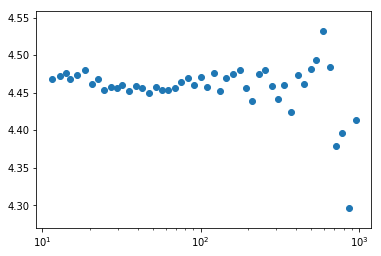

In [61]:
plt.scatter(grouped_product_n_reviews['n_reviews'], grouped_product_n_reviews['rating'])
plt.xscale('log')

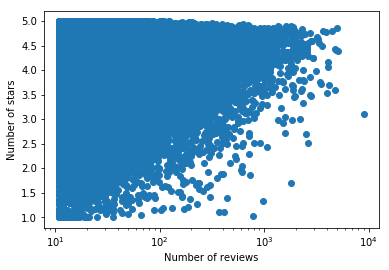

In [16]:
plt.scatter(by_product['n_reviews'], by_product['rating'])
plt.xscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Number of stars')
plt.show()

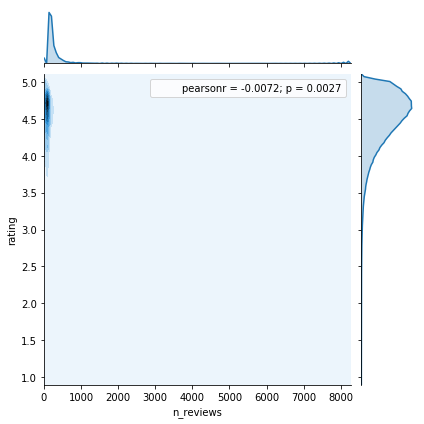

In [46]:
sns.jointplot(x = by_product['n_reviews'], y = by_product['rating'], kind='kde')

**Observation**<br>
We can see that the higher the number of reviews is, the higher the rating. However, the causal relationship is most likely causal in the sense that better products have higher ratings, but better products also have more people that buy them, so more reviews.

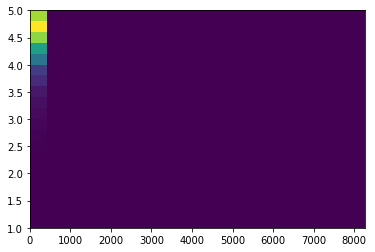

In [101]:
plt.hist2d(by_product['n_reviews'], by_product['rating'], bins=20)
#plt.xlim(0, 100)
plt.show()

## 2.3 Analysis of Time Based Features

In [142]:

def get_time_analysis(data, time_name):
    time_types = {'month' : month('date'), 'year' : year('date'), 'dayofweek' : dayofweek('date'), 'dayofmonth' : dayofmonth('date')}
    group_function = time_types[time_name]
    data_bytime = data.groupby(group_function).agg(f.avg('star_rating'), f.count('review_id'), f.stddev('star_rating')).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('stddev_samp(star_ratinng)', 'std_rating').withColumnRenamed(time_name + '(date)', time_name)
    data_bytime_sorted = data_bytime.sort(time_name)
    
    
    by_time_pd = data_bytime_sorted.toPandas()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    ax1.plot(by_time_pd[time_name], by_time_pd['rating'])
    ax1.fill_between(by_time_pd[time_name], by_time_pd['rating'] - 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), \
                                           by_time_pd['rating'] + 1.96 * by_time_pd['stddev_samp(star_rating)'] / np.sqrt(by_time_pd['count(review_id)']), alpha=0.5)
    ax1.set_xlabel(time_name)
    ax1.set_ylabel('Average Rating')
    ax1.set_title('Avergage Rating vs ' + time_name)
    
    ax2.plot(by_time_pd[time_name], by_time_pd['count(review_id)'])
    
    ax2.set_xlabel(time_name)
    ax2.set_ylabel('Number of reviews')
    ax2.set_title('Number of ratings vs ' + time_name)
    plt.show()
    

In [143]:
by_time = data.select(data['star_rating'],to_timestamp(data['review_date'], 'yyyy-MM-dd').alias('date'), data['review_id'])

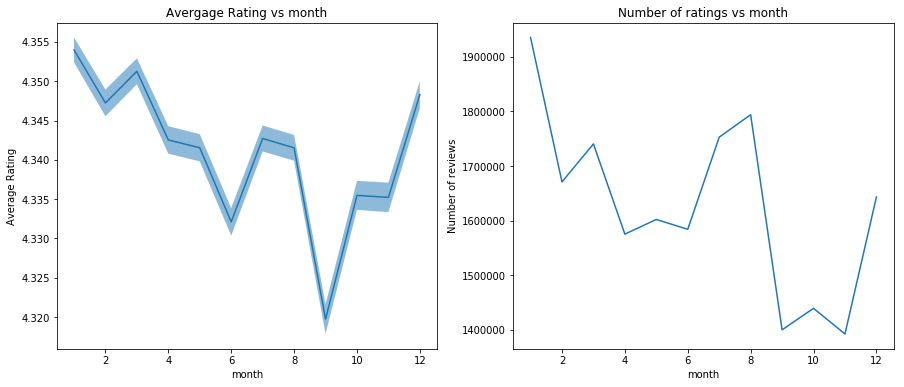

In [144]:
get_time_analysis(by_time, 'month')

In [145]:
get_time_analysis(by_time, 'year')

KeyboardInterrupt: 

In [ ]:
get_time_analysis(by_time, 'dayofweek')

In [ ]:
get_time_analysis(by_time, 'dayofmonth')

## 2.4 Text analysis

In [146]:
div_by_10 = udf(lambda x : 0 if x is None else 1*int(x / 10))
div_by_100 = udf(lambda x : 0 if x is None else 10*int(x / 100))
by_review_length = data.select(data['star_rating'], \
                               div_by_10(length(data['review_headline'])).alias('title_length'), \
                               div_by_100(length(data['review_body'])).alias('body_length'), \
                                      data['review_id'])
by_review_length.persist()

DataFrame[star_rating: string, title_length: string, body_length: string, review_id: string]

In [147]:
by_review_length.show()

+-----------+------------+-----------+--------------+
|star_rating|title_length|body_length|     review_id|
+-----------+------------+-----------+--------------+
|          5|           1|          0| RJOVP071AVAJO|
|          5|           6|         30|R1ORGBETCDW3AI|
|          5|           1|          0| R7TNRFQAOUTX5|
|          5|           1|          0|R2GANXKDIFZ6OI|
|          5|           1|          0|R2NYB6C3R8LVN6|
|          2|           3|        150|R13U5PBJI1H94K|
|          5|           5|         70|R1H8UVH990F8VE|
|          5|           1|          0|R2MC0N30WZMRQ5|
|          5|           1|          0| R2NO2HXK16Y4J|
|          5|           1|          0|R245YIAVJK82ZL|
|          5|           1|          0| RFBMLBWQOZ1UM|
|          5|           3|         10| RHE1FEWV3KTQH|
|          5|           1|          0|R2BB9U7PHO7ETO|
|          4|           1|          0|R28XJJP754GYXO|
|          3|           7|         20|R2G519UREHRO8M|
|          5|           1|  

In [148]:

by_title_length = by_review_length.where('title_length < 300').groupby('title_length').agg({'star_rating':'avg', 'review_id':'count'}).\
                    withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_title_length.persist()

DataFrame[title_length: string, count: bigint, rating: double]

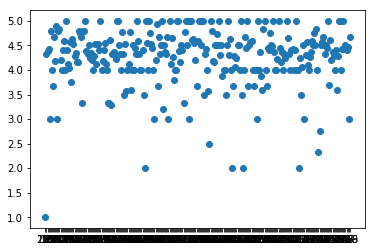

In [149]:
by_title_length_pd = by_title_length.toPandas()
by_title_length_pd
plt.scatter(by_title_length_pd['title_length'], by_title_length_pd['rating'])

In [35]:
by_body_length = by_review_length.groupby('body_length').agg({'star_rating':'avg', 'review_id':'count'}) \
                    .withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_body_length.persist()

DataFrame[body_length: string, count: bigint, rating: double]

In [ ]:
by_body_length.count()

In [ ]:
by_body_length_pd = by_body_length.toPandas()
by_body_length_pd
plt.plot(by_body_length_pd['body_length'], by_body_length_pd['count'])

## 2.5 Comparaison betwen countries

Compare for common articles on the same time period, do analysis. => Get average rating for country

## 2.6 Herding behavior

Do we have enough data to perform this analysis ?

For common articles in every countries, get the first review and compare it to the average review. Correct the bias due to the difference between countries.